In [ ]:
from pathlib import Path
from pyproj import CRS, Transformer

import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry
import matplotlib.pyplot as plt

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# reading input scenario
urbansim_source_dir = "../beam_root/production/sfbay/urbansim"

persons = pd.read_csv(f"{urbansim_source_dir}/persons.csv.gz")
households = pd.read_csv(f"{urbansim_source_dir}/households.csv.gz")
plans = pd.read_csv(f"{urbansim_source_dir}/plans.csv.gz")
blocks = pd.read_csv(f"{urbansim_source_dir}/blocks.csv.gz")

plans_columns = plans.columns

print(f"Number of persons: {persons.shape[0]}, number of households: {households.shape[0]}, number of unique persons in plans: {plans['person_id'].nunique()}")

Number of persons: 721814, number of households: 275783, number of unique persons in plans: 646773


In [43]:
# reading the shp file and converting it to activities `x` and `y` CRS
# also using only selected districts of the shape file

id_path = "../local_files/sf-light/sfbay-geo-units.csv"
id_df = pd.read_csv(id_path)

shape_file_path = "../beam_root/production/sfbay/shape/sfbay-tazs-epsg-26910.shp"

# reading the shape file
shp_df_wrong_crs = gpd.read_file(shape_file_path)

# converting the shapefile to required CRS
shp_df_full = shp_df_wrong_crs.to_crs(4326)


# using only selected districts
selected_districts = set([8, 9, 10, 11, 12, 13, 14])
shp_df = shp_df_full[shp_df_full['objectid'].isin(id_df['objectid'])]

print(f"Selected districts has: {len(shp_df)} rows, full shape file has {len(shp_df_full)} rows.")
display(shp_df.head(2))

Selected districts has: 193 rows, full shape file has 1454 rows.


,objectid,taz1454,district,county,gacres,Shape__Are,Shape__Len,geometry
338,339,1,1,San Francisco,32.530647,0.000008,0.012199,"POLYGON ((-122.39970 37.79223, -122.39990 37.7..."
339,340,3,1,San Francisco,23.589885,0.000006,0.010129,"POLYGON ((-122.40699 37.79032, -122.40710 37.7..."


In [5]:
# getting CRS of the shp file
shp_df.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [ ]:
# saving filtered-out shapefile dataframe to files (by folder path)
# shp_df.to_file("../local_files/vta-filtering-plans/MTC-1454-TAZ-selected-districts")

In [6]:
plans['trip_from'] = plans['trip_id'].shift(-1)
plans['trip_to'] = plans['trip_id'].shift(1)

plans_extra_columns = plans.columns

# sanity check, the resulting selections should be empty
plans['person_shift_1'] = plans['person_id'].shift(-1)
plans['person_shift_2'] = plans['person_id'].shift(1)

print("Both Series should be empty (column for selected rows contains only NaN)")
display(plans[plans['person_id'] != plans['person_shift_1']]['trip_from'].value_counts())
display(plans[plans['person_id'] != plans['person_shift_2']]['trip_to'].value_counts())

# removing extra columns
plans = plans[plans_extra_columns]

plans.head(5)

Both Series should be empty (column for selected rows contains only NaN)


Series([], Name: trip_from, dtype: int64)

Series([], Name: trip_to, dtype: int64)

,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time,trip_from,trip_to
0,NaN,4.0,NaN,NaN,1,activity,Home,-122.227937,37.854097,14.392,1513.0,NaN
1,1513.0,4.0,1.0,SHARED3PAY,2,leg,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,4.0,NaN,NaN,3,activity,othdiscr,-122.268361,37.807814,18.145,1517.0,1513.0
3,1517.0,4.0,1.0,WALK_LOC,4,leg,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,4.0,NaN,NaN,5,activity,Home,-122.227937,37.854097,NaN,NaN,1517.0


In [7]:
# getting activities

activities = plans[plans['ActivityElement'] == 'activity']

# sanity check
if 0 == activities[['person_id','x','y']].isna().sum().sum():
    print(f'All persons, activities and X Y coordinates are set. Number of activities: {len(activities)}')

display(activities.head(2))

All persons, activities and X Y coordinates are set. Number of activities: 3184936


,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time,trip_from,trip_to
0,NaN,4.0,NaN,NaN,1,activity,Home,-122.227937,37.854097,14.392,1513.0,NaN
2,NaN,4.0,NaN,NaN,3,activity,othdiscr,-122.268361,37.807814,18.145,1517.0,1513.0


In [8]:
# getting geo_activities dataframe with specified CRS

points = gpd.points_from_xy(activities["x"], activities["y"], crs="EPSG:4326")
geo_activities = gpd.GeoDataFrame(activities, geometry=points)
geo_activities.head(2)

,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time,trip_from,trip_to,geometry
0,NaN,4.0,NaN,NaN,1,activity,Home,-122.227937,37.854097,14.392,1513.0,NaN,POINT (-122.22794 37.85410)
2,NaN,4.0,NaN,NaN,3,activity,othdiscr,-122.268361,37.807814,18.145,1517.0,1513.0,POINT (-122.26836 37.80781)


In [9]:
# getting activities within shape file

# `predicate` must be one of {'covers', 'within', 'contains', 'contains_properly', 'covered_by', 'intersects', 'crosses', 'overlaps', None, 'touches'}
geo_activities_within_area = geo_activities.sjoin(shp_df, predicate="within")
outside_activities = geo_activities.loc[~geo_activities.index.isin(geo_activities_within_area.index)]
# calculating how many persons there are in original activities and with activities within shape file
persons_outside_area = set(outside_activities['person_id'].unique())

persons_within_area = set(geo_activities_within_area['person_id'].unique()) - persons_outside_area
persons_total = activities['person_id'].nunique()

print(f"Activities within selected shape file: {len(geo_activities_within_area)}, total activities: {len(geo_activities)}.")
print(f"Persons within selected shape file: {len(persons_within_area)}, total persons: {persons_total}")

geo_activities_within_area.head(2)

Activities within selected shape file: 383592, total activities: 3184936.
Persons within selected shape file: 54676, total persons: 646773


,trip_id,person_id,number_of_participants,trip_mode,PlanElementIndex,ActivityElement,ActivityType,x,y,departure_time,trip_from,trip_to,geometry,index_right,objectid,taz1454,district,county,gacres,Shape__Are,Shape__Len
202,NaN,189.0,NaN,NaN,3,activity,work,-122.396724,37.788182,17.613,62309.0,62305.0,POINT (-122.39672 37.78818),342,343,13,1,San Francisco,42.443168,0.000011,0.013545
628,NaN,617.0,NaN,NaN,3,activity,work,-122.398522,37.787479,18.933,202693.0,202689.0,POINT (-122.39852 37.78748),342,343,13,1,San Francisco,42.443168,0.000011,0.013545


In [37]:
persons_no_plans = persons[~persons['person_id'].isin(plans['person_id'])]
print(f"Persons no plans: {len(persons_no_plans)}")
households_no_plans = persons[persons['person_id'].isin(persons_no_plans['person_id'])]['household_id'].unique()
print(f"HH no plans: {len(households_no_plans)}")
households_outside_area = persons[persons['person_id'].isin(persons_outside_area)]['household_id'].unique()
households_within_area = households.loc[~households['household_id'].isin(households_outside_area)]
print(f"HH outside area: {len(households_outside_area)}, HH within area: {len(households_within_area)}, total HH: {len(households)}")
households_with_plans = households_within_area.loc[~households_within_area['household_id'].isin(households_no_plans)]
print(f"HH within area with plans {len(households_with_plans)}")
selected_households = households_with_plans.sample(n = 5000)
selected_persons = persons[persons['household_id'].isin(selected_households['household_id'])]['person_id']
print(f"Selected persons: {len(selected_persons)}")


Persons no plans: 75041
HH no plans: 52716
HH outside area: 245605, HH within area: 30178, total HH: 275783
HH within area with plans 19563
Selected persons: 8335


In [ ]:
# saving activities locations to shape file
# saving geo dataframe to shape file takes time
# this step here is for sanity check


# df1 = geo_activities[geo_activities['person_id'].isin(persons_within_area)]
# df2 = geo_activities[~geo_activities['person_id'].isin(persons_within_area)]

# df1.to_file(filename="../local_files/vta-filtering-plans/activities_of_persons_with_OD_within_area_shape", driver='ESRI Shapefile')
# df2.to_file(filename="../local_files/vta-filtering-plans/activities_of_persons_with_OD_outside_area_shape", driver='ESRI Shapefile')

# # saving activities within area
# geo_activities_within_area.to_file(filename="../local_files/vta-filtering-plans/activities_only_within_area_shape", driver='ESRI Shapefile')

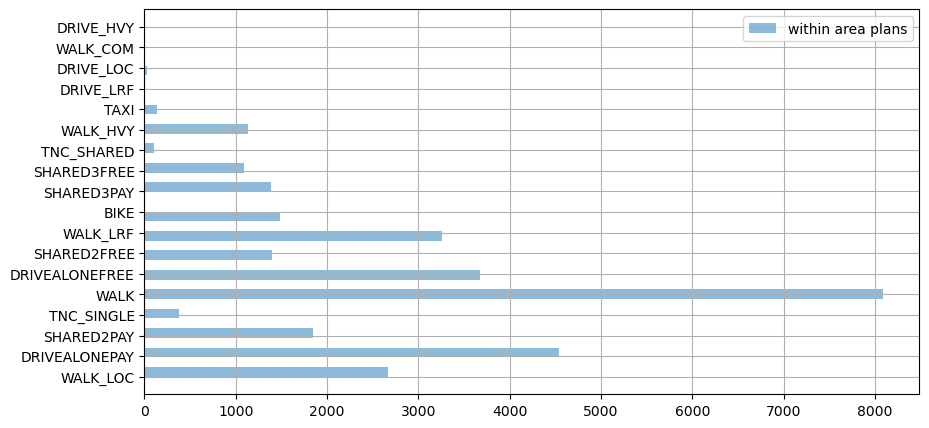

In [38]:
# sanity check

_, ax = plt.subplots(1, 1, figsize=(10,5))

# plans['trip_mode'].hist(ax=ax, bins=36, alpha=0.5, label="original plans", orientation='horizontal')
plans[plans['person_id'].isin(selected_persons)]['trip_mode'].hist(ax=ax, bins=36, alpha=0.5, label="within area plans", orientation='horizontal')

# ax.tick_params(axis='x', labelrotation=75)
ax.legend()

# approach #1 - downsampling

In [39]:
# downsampling scenario based on selected persons
# usually we take persons ids, then households, then take all persons within households, but this time I took only selected persons 

selected_persons_df = persons[persons['person_id'].isin(selected_persons)]
print(f"there are {len(selected_persons_df)} selected persons (out of {len(persons)})")

selected_households_ids = set(selected_persons_df['household_id'].unique())
selected_households_df = households[households['household_id'].isin(selected_households_ids)]
print(f"there are {len(selected_households_df)} selected households (out of {len(households)})")

selected_plans_df = plans[plans['person_id'].isin(selected_persons)]
print(f"there are {len(selected_plans_df)} selected plans (out of {len(plans)})")

selected_block_ids = set(selected_households_df['block_id'])
selected_blocks_df = blocks[blocks['block_id'].isin(selected_block_ids)]
print(f"there are {len(selected_blocks_df)} selected blocks (out of {len(blocks)})")

there are 8335 selected persons (out of 721814)
there are 5000 selected households (out of 275783)
there are 70805 selected plans (out of 5723099)
there are 2326 selected blocks (out of 109228)


<AxesSubplot: >

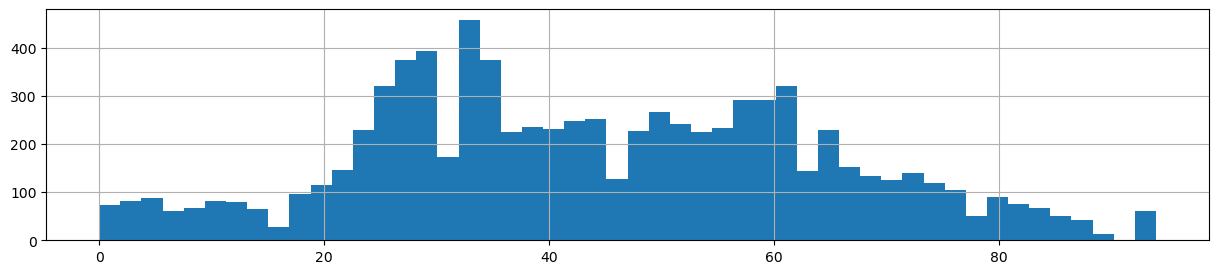

In [40]:
# sanity check

selected_persons_df['age'].hist(bins=50, figsize=(15,3))

In [42]:
# saving downsampled scenario to output dir

out_dir = '../beam_root/test/input/sf-light/urbansim/hh5k'

Path(out_dir).mkdir(parents=True, exist_ok=True)

selected_persons_df.to_csv(f'{out_dir}/persons.csv.gz', index=False, compression='gzip')
selected_households_df.to_csv(f'{out_dir}/households.csv.gz', index=False, compression='gzip')
selected_plans_df.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')
selected_blocks_df.to_csv(f'{out_dir}/blocks.csv.gz', index=False, compression='gzip')

# approach #2 - clearing modes for selected persons

In [ ]:
# splitting plans into two dataframes based on selected persons IDs and clearing modes for selected persons plans

plans_within = plans[plans['person_id'].isin(persons_within_area)].copy()
plans_rest = plans[~plans['person_id'].isin(persons_within_area)].copy()

# reset modes
plans_within['trip_mode'] = np.nan

# concat two dataframes back with sorting by person Id and plan element index
plans_cleared = pd.concat([plans_within,plans_rest]).sort_values(['person_id','PlanElementIndex'])

plans_within['person_id'].nunique(), plans_rest['person_id'].nunique(), plans_cleared['person_id'].nunique()

In [ ]:
# check if everything apart modes are equal in old plans and changed plans
columns = ["trip_id","person_id","number_of_participants","PlanElementIndex","ActivityElement","ActivityType","x","y","departure_time"]
plans_cleared[columns].equals(plans[columns])

In [ ]:
# sanity check

ax = plans['trip_mode'].hist(figsize=(15,3), xrot=20, alpha=0.5, label="original plans")
plans_cleared['trip_mode'].hist(ax=ax, alpha=0.5, label="cleared plans")
ax.legend()

In [ ]:
# saving changed plans to output dir

out_dir = 'sampled_scenario'

Path(out_dir).mkdir(parents=True, exist_ok=True)

selected_households_df.to_csv(f'{out_dir}/households.csv.gz', index=False, compression='gzip')
selected_persons_df.to_csv(f'{out_dir}/persons.csv.gz', index=False, compression='gzip')
selected_blocks_df.to_csv(f'{out_dir}/blocks.csv.gz', index=False, compression='gzip')

plans_cleared.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')

# approach #3 remove plans\people with only specific modes and with all OD outside the study area

In [ ]:
# looking for plans for persons outside of study area 

plans_outside_area = plans[~plans['person_id'].isin(persons_within_area)]
print(f"there are {plans_outside_area['person_id'].nunique()} persons with plans outside of study area")
plans_outside_area.head(2)

In [ ]:
# take only trips (with trip mode not NA)
df1 = plans_outside_area[~plans_outside_area['trip_mode'].isna()]

# take only plans that are not contains selected modes:
modes_to_filter_out = set(['DRIVEALONEFREE','DRIVEALONEPAY','SHARED2FREE','SHARED2PAY','SHARED3FREE','SHARED3PAY','WALK','BIKE'])
df2 = df1[~df1['trip_mode'].isin(modes_to_filter_out)]

# take ID of persons outside area with allowed modes
persons_outside_with_allowed_modes = set(df2['person_id'].unique())

persons_within_and_outside_with_allowed_modes = set()
persons_within_and_outside_with_allowed_modes.update(persons_within_area)
persons_within_and_outside_with_allowed_modes.update(persons_outside_with_allowed_modes)

len(persons_within_and_outside_with_allowed_modes), len(persons_outside_with_allowed_modes)

In [ ]:
# filtering persons, households and blocks based on selected persons
# usually we take persons ids, then households, then take all persons within households, but this time I took only selected persons 

selected_persons_df = persons[persons['person_id'].isin(persons_within_and_outside_with_allowed_modes)]
print(f"there are {len(selected_persons_df)} selected persons (out of {len(persons)})")

selected_households_ids = set(selected_persons_df['household_id'].unique())
selected_households_df = households[households['household_id'].isin(selected_households_ids)]
print(f"there are {len(selected_households_df)} selected households (out of {len(households)})")

selected_block_ids = set(selected_households_df['block_id'])
selected_blocks_df = blocks[blocks['block_id'].isin(selected_block_ids)]
print(f"there are {len(selected_blocks_df)} selected blocks (out of {len(blocks)})")

In [ ]:
# sanity check

_, ax = plt.subplots(1, 1, figsize=(10,5))

bins = plans['trip_mode'].nunique() * 2

def plot_hist(plans_df, label):
    plans_df['trip_mode'].hist(ax=ax, alpha=0.5, histtype="step", bins=bins, linewidth=2, label=label, orientation='horizontal')

plot_hist(plans, label="original plans")
plot_hist(plans[plans['person_id'].isin(persons_within_area)], label="within area plans")
plot_hist(plans_outside_area, label="outside area plans")
plot_hist(plans[plans['person_id'].isin(persons_outside_with_allowed_modes)], label="outside area with allowed modes plans")

ax.legend()

In [ ]:
# # saving activities for all persons with OD within area and outside with allowed modes

# df1 = geo_activities[geo_activities['person_id'].isin(persons_within_and_outside_with_allowed_modes)]
# df1.to_file(filename="../local_files/vta-filtering-plans/plans_of_persons_with_OD_within_area_shape", driver='ESRI Shapefile')

# approach 3.1 just remove persons outside with only specific modes

In [ ]:
# downsampling scenario based on selected persons

selected_plans_df = plans[plans['person_id'].isin(persons_within_and_outside_with_allowed_modes)]
print(f"there are {len(selected_plans_df)} selected plans (out of {len(plans)})")

In [ ]:
# saving downsampled scenario to output dir

out_dir = 'sampled_scenario__within_area_plus_outside_with_allowed_modes__with_modes'

Path(out_dir).mkdir(parents=True, exist_ok=True)

selected_persons_df.to_csv(f'{out_dir}/persons.csv.gz', index=False, compression='gzip')
selected_households_df.to_csv(f'{out_dir}/households.csv.gz', index=False, compression='gzip')
selected_plans_df.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')
selected_blocks_df.to_csv(f'{out_dir}/blocks.csv.gz', index=False, compression='gzip')

# approach 3.2 + clear modes for trips in study area

In [ ]:
# getting trip ids for all activities within study area

trips_from_activities_within_area = set(geo_activities_within_area['trip_from'].unique())
trips_to_activities_within_area = set(geo_activities_within_area['trip_to'].unique())

trips_within_area = set()
trips_within_area.update(trips_to_activities_within_area)
trips_within_area.update(trips_from_activities_within_area)
print(f"There are {len(trips_within_area)} trips within area, ({plans['trip_id'].nunique()} total plans)")

In [ ]:
# splitting plans into two dataframes based on selected trips IDs and clearing modes for selected persons plans

plans_within = plans[plans['person_id'].isin(persons_within_and_outside_with_allowed_modes)]

trips_within = plans_within[plans_within['trip_id'].isin(trips_within_area)].copy()
trips_outside = plans_within[~plans_within['trip_id'].isin(trips_within_area)].copy()

# reset modes
trips_within['trip_mode'] = np.nan

# concat two dataframes back with sorting by person Id and plan element index
selected_plans_area_without_modes_df = pd.concat([trips_within, trips_outside]).sort_values(['person_id','PlanElementIndex'])[plans_columns]
print(len(selected_plans_area_without_modes_df))

selected_plans_area_without_modes_df.head(2)

In [ ]:
# sanity check

_, ax = plt.subplots(1, 1, figsize=(10,5))

def plot_hist(plans_df, label):
    plans_df['trip_mode'].hist(ax=ax, alpha=0.5, histtype="step", bins=20, linewidth=5, label=label, orientation='horizontal')

plot_hist(plans, label="original plans")
plot_hist(plans[plans['person_id'].isin(persons_within_and_outside_with_allowed_modes)], label="filtered plans")
plot_hist(selected_plans_area_without_modes_df, label="filtered plans with clear modes within area")

ax.legend()

In [ ]:
# saving downsampled scenario to output dir

# out_dir = 'sampled_scenario__within_area_plus_outside_with_allowed_modes__area_without_modes'
out_dir = 'sampled_scenario'

Path(out_dir).mkdir(parents=True, exist_ok=True)

selected_persons_df.to_csv(f'{out_dir}/persons.csv.gz', index=False, compression='gzip')
selected_households_df.to_csv(f'{out_dir}/households.csv.gz', index=False, compression='gzip')
selected_blocks_df.to_csv(f'{out_dir}/blocks.csv.gz', index=False, compression='gzip')

selected_plans_area_without_modes_df.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')

# approach 3.3 + clear modes for persons with OD within study area

In [ ]:
# splitting plans into two dataframes based on selected persons IDs and clearing modes for selected persons plans

plans_within = plans[plans['person_id'].isin(persons_within_area)].copy()
plans_rest = plans[plans['person_id'].isin(persons_outside_with_allowed_modes)].copy()

# reset modes
plans_within['trip_mode'] = np.nan

# concat two dataframes back with sorting by person Id and plan element index
selected_plans_area_without_modes_df = pd.concat([plans_within, plans_rest]).sort_values(['person_id','PlanElementIndex'])
selected_plans_area_without_modes_df.shape

In [ ]:
# saving downsampled scenario to output dir

out_dir = 'sampled_scenario__v1_30pct_study_area_without_modes'

Path(out_dir).mkdir(parents=True, exist_ok=True)

selected_persons_df.to_csv(f'{out_dir}/persons.csv.gz', index=False, compression='gzip')
selected_households_df.to_csv(f'{out_dir}/households.csv.gz', index=False, compression='gzip')
selected_blocks_df.to_csv(f'{out_dir}/blocks.csv.gz', index=False, compression='gzip')

selected_plans_area_without_modes_df.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')

# approach 3.4 + clear all modes

In [ ]:
# removing all modes altogether
selected_plans_without_modes_df = plans[plans['person_id'].isin(persons_within_and_outside_with_allowed_modes)].copy()
selected_plans_without_modes_df['trip_mode'] = np.nan

In [ ]:
# saving downsampled scenario to output dir

out_dir = 'sampled_scenario__v1_30pct__without_modes'

Path(out_dir).mkdir(parents=True, exist_ok=True)

selected_persons_df.to_csv(f'{out_dir}/persons.csv.gz', index=False, compression='gzip')
selected_households_df.to_csv(f'{out_dir}/households.csv.gz', index=False, compression='gzip')
selected_blocks_df.to_csv(f'{out_dir}/blocks.csv.gz', index=False, compression='gzip')

selected_plans_without_modes_df.to_csv(f'{out_dir}/plans.csv.gz', index=False, compression='gzip')

# sanity check

In [ ]:
plans1 = pd.read_csv("sampled_scenario__within_area_plus_outside_with_allowed_modes__with_modes/plans.csv.gz", low_memory=False)
plans2 = pd.read_csv("sampled_scenario__within_area_plus_outside_with_allowed_modes__area_without_modes/plans.csv.gz", low_memory=False)
plans3 = pd.read_csv("sampled_scenario__within_area_plus_outside_with_allowed_modes__without_modes/plans.csv.gz", low_memory=False)


ax = plans1['trip_mode'].hist(figsize=(15,3), xrot=20, alpha=0.5, label="with modes")
plans2['trip_mode'].hist(ax=ax, alpha=0.5, label="area without modes")
plans3['trip_mode'].hist(ax=ax, alpha=0.5, label="no modes")

ax.legend()